In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD
from keras.optimizers import Adam
import numpy as np
from sklearn.datasets import fetch_lfw_pairs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    
    layers.RandomZoom(0.1),
])

lfw_pairs_train = fetch_lfw_pairs(subset='train',color=True)
pairs = lfw_pairs_train.pairs   
labels = lfw_pairs_train.target

augmented_pairs = []
augmented_labels = []

for i in range(len(pairs)):
    img1, img2 = pairs[i]
    label = labels[i]
    aug_img1 = data_augmentation(img1)
    aug_img2 = data_augmentation(img2)
    augmented_pairs.append([aug_img1.numpy(), aug_img2.numpy()])
    augmented_labels.append(label)

pairs_expanded = np.concatenate([pairs, np.array(augmented_pairs)], axis=0)
labels_expanded = np.concatenate([labels, np.array(augmented_labels)], axis=0)

pairs_train, pairs_test, labels_train, labels_test = train_test_split(
    pairs_expanded, labels_expanded, test_size=0.25, random_state=42, shuffle=True
)

Generation pairs of images from LFW dataset extended with augmented variants

In [50]:
def residual_block(x, filters, kernel_size=3, stride=1):
   
    shortcut = x
    
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
  
    if shortcut.shape[-1] != filters or stride > 1:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def encoder(input_shape, latent_dim):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)  
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)  
    x = residual_block(x, 256)
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    conv7 = layers.Conv2D(64, (7, 7), padding='same', activation='relu')(x)
    merged = layers.concatenate([conv3, conv5, conv7])
    attention = layers.Conv2D(192, (1,1), activation='sigmoid')(merged)
    weighted = layers.Multiply()([merged, attention])
    x = layers.GlobalAveragePooling2D()(weighted)
    x = layers.Dropout(0.1)(x)
    latent = layers.Dense(
        latent_dim, 
        activation='relu',
        kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        name='latent'
    )(x)
    return keras.Model(inputs, latent, name='encoder')

Encoder and ReSu cores for encoding images and downsample them

In [51]:
input_shape = (62, 47, 3)
latent_dim = 64
encode=encoder(input_shape,latent_dim)

input_a=keras.Input(shape=input_shape)
input_b=keras.Input(shape=input_shape)

embedding_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_a))
embedding_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(encode(input_b))


distance = layers.Lambda(lambda emb: tf.norm(emb[0] - emb[1], axis=1, keepdims=True))(
    [embedding_a, embedding_b]
)
siamese_model = keras.Model(inputs=[input_a, input_b], outputs=distance)


def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) + 
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)


normalazing data and making contrastive loss func based on eucliud's distance

In [52]:
siamese_model.compile(optimizer=SGD(learning_rate=0.1), loss=contrastive_loss, metrics=[])
history = siamese_model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    batch_size=16,
    epochs=20,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    callbacks=[early_stopping]
)


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 0.2812 - val_loss: 0.4862
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.2478 - val_loss: 0.2620
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.2282 - val_loss: 0.2712
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.2163 - val_loss: 0.2116
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.2001 - val_loss: 0.2132
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.1861 - val_loss: 0.2129
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.1705 - val_loss: 0.2450
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.1569 - val_loss: 0.1902
Epoch 9/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.1335 - val_loss: 0.2134
Epoch 10/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 0.1170 - val_loss: 0.2238
Epoch 11/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 0.1122 - val_loss: 0.2296
Epoch 12/20
207/207

training the model

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Test AUC: 0.9133


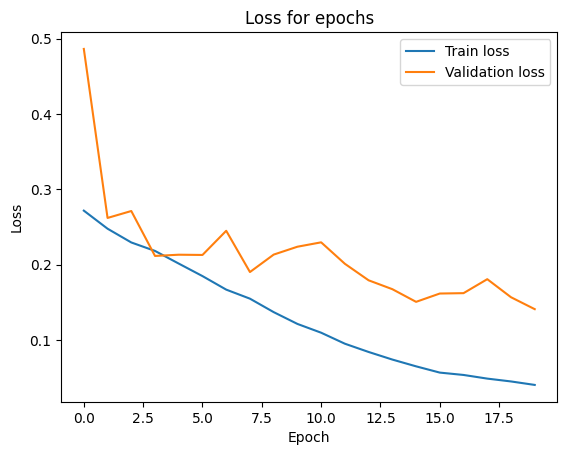

In [53]:
distances_test = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]])
auc = roc_auc_score(labels_test, -distances_test)  
print(f"Test AUC: {auc:.4f}")

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for epochs')
plt.legend()
plt.show()


loss for epochs graphs and ROC AUC stats

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


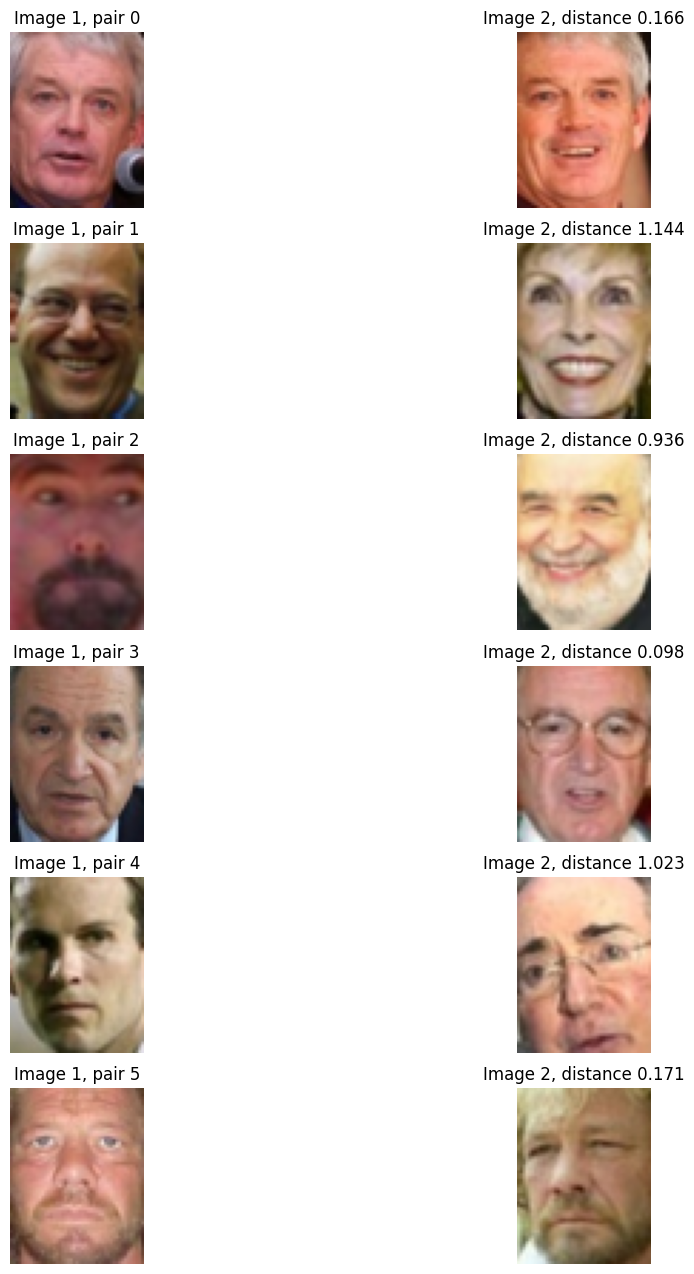

In [54]:

plt.figure(figsize=(12, 16))
for im in range(6):  
    img1 = pairs_test[im][0]
    img2 = pairs_test[im][1]
    img1_batch = img1[np.newaxis, ...]
    img2_batch = img2[np.newaxis, ...]
    distance_val = siamese_model.predict([img1_batch, img2_batch])
    plt.subplot(6, 2, 2*im+1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title(f'Image 1, pair {im}')
    plt.axis('off')
    plt.subplot(6, 2, 2*im+2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title(f'Image 2, distance {distance_val[0][0]:.3f}')
    plt.axis('off')
plt.show()

example of working 